# PROBLEM STATEMENT

The objective is to develop a predictive model that estimates the insurance premium a customer should pay based on their personal characteristics and risk-related factors. The model should account for diverse risk profiles and accurately determine appropriate premium amounts tailored to each customer's unique situation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sweetviz
from scipy import stats
stats.chisqrob = lambda chisq, df:stats.chi2.sf(chisq, df)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import boxcox, probplot


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


import shap
import lime
shap.initjs()
sns.set()


C:\Users\ntabi\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA LOADING

In [2]:
data= pd.read_excel('Data1.xlsx')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,Gauteng,16884.92
1,18,male,33.770,1,no,Western Cape,1725.55
2,28,male,33.000,3,no,Western Cape,4449.46
3,33,male,22.705,0,no,KZN,21984.47
4,32,male,28.880,0,no,KZN,3866.86


### EDA USING SWEETVIZ

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



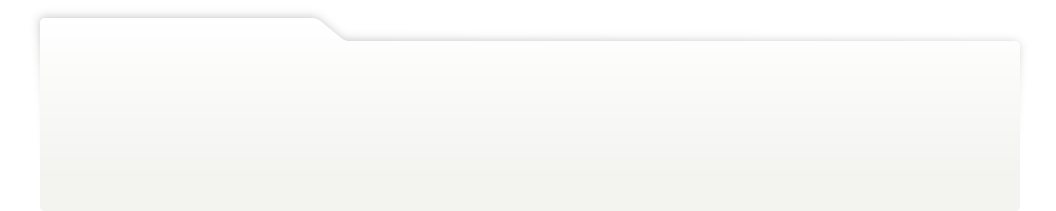
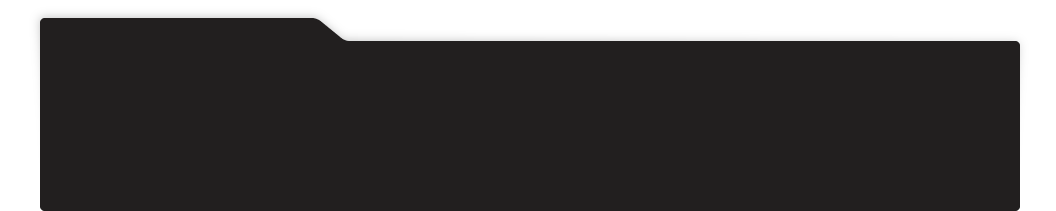
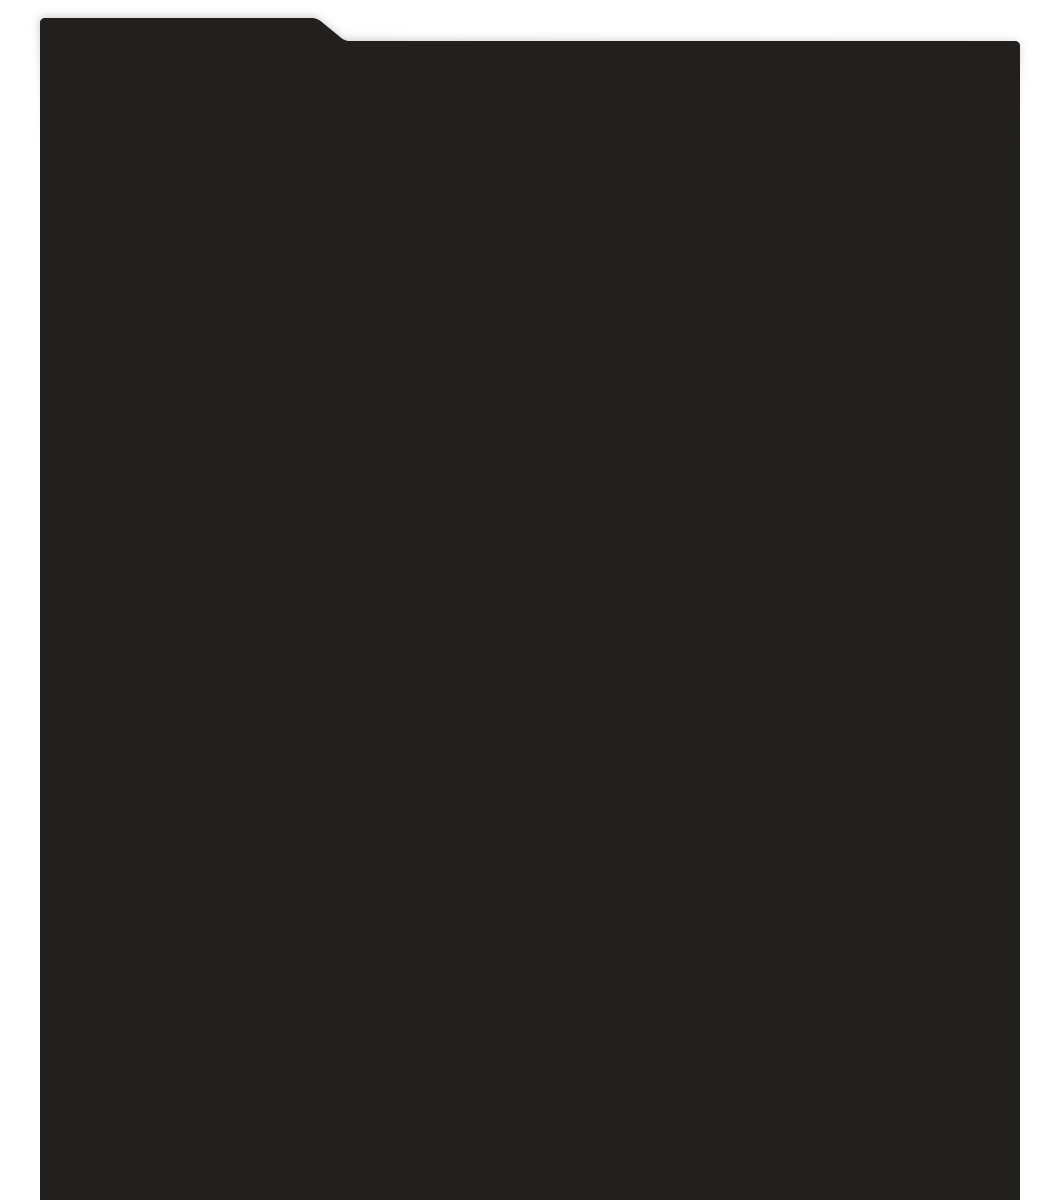
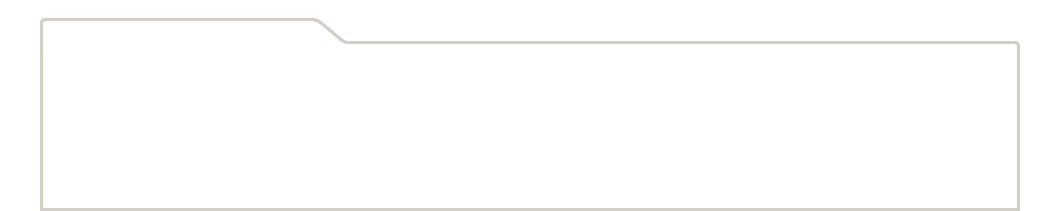
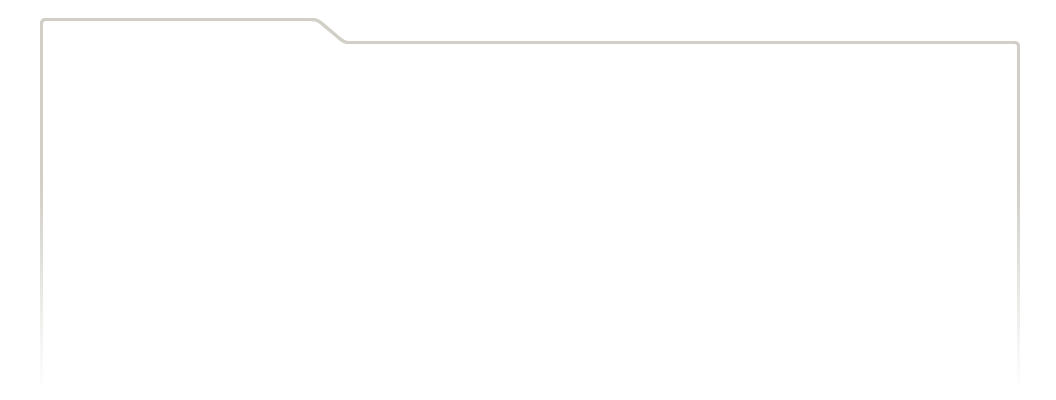
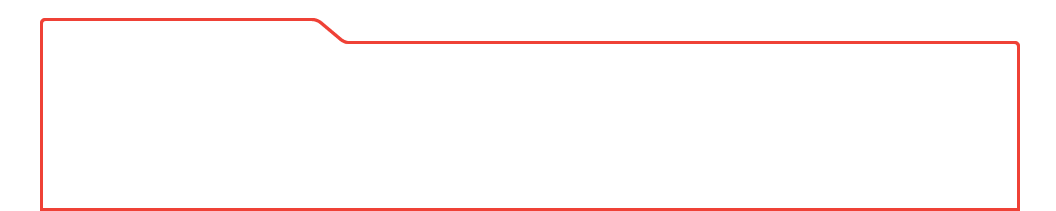
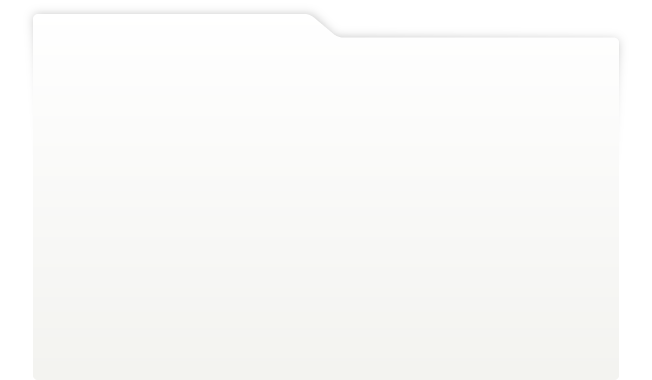
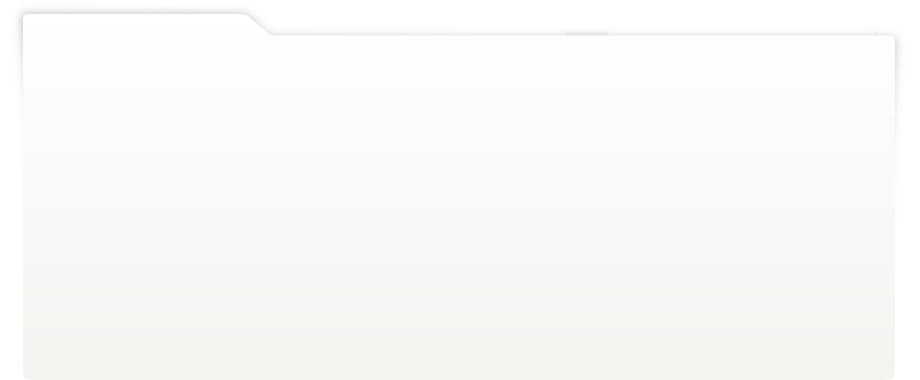
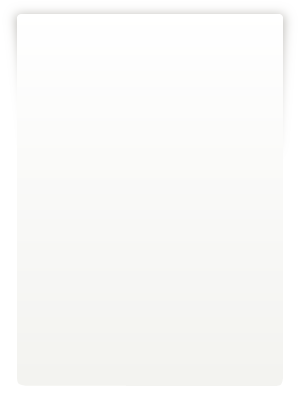
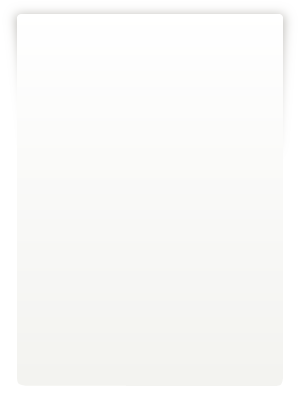
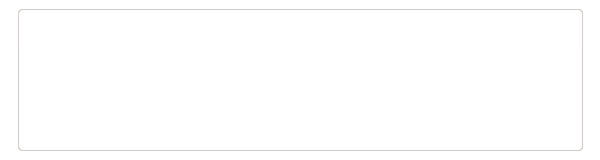
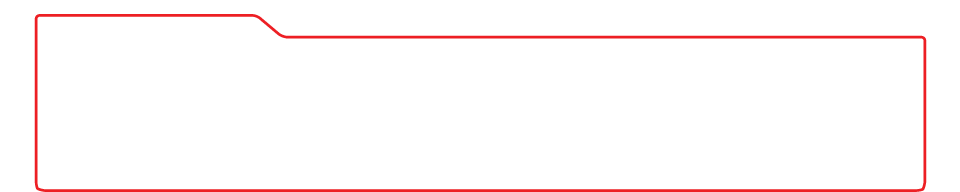
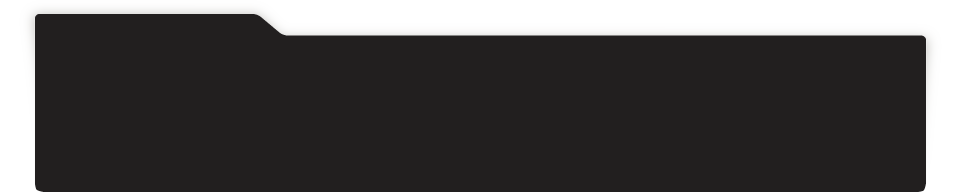
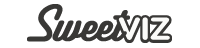
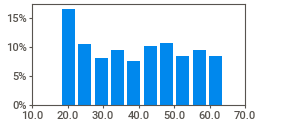
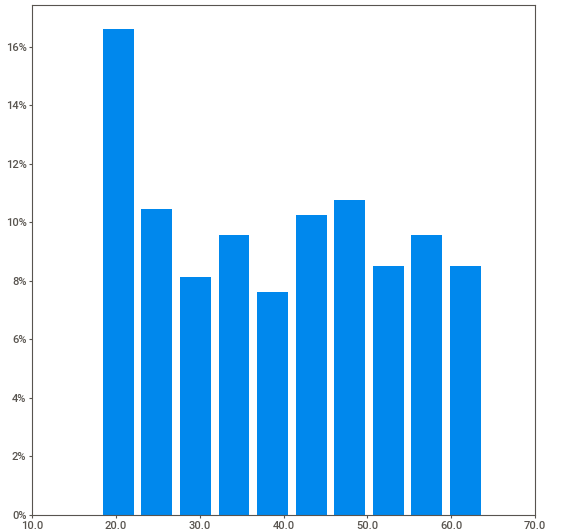
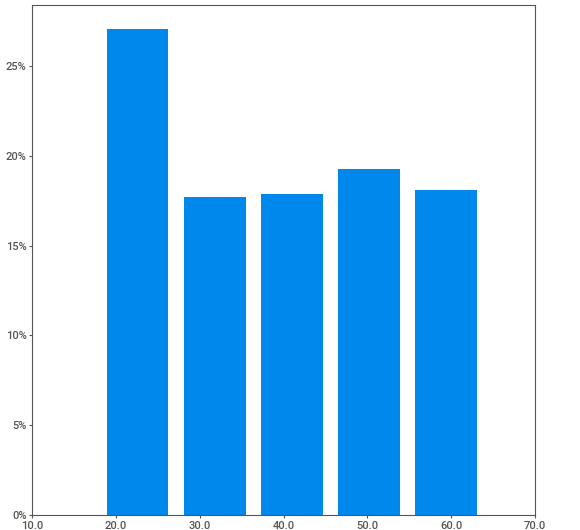
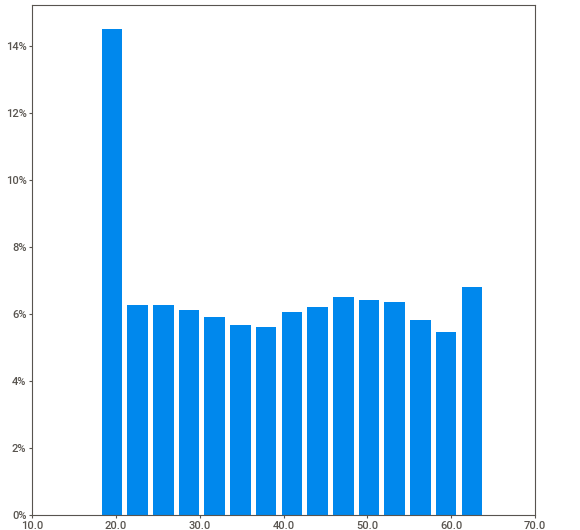
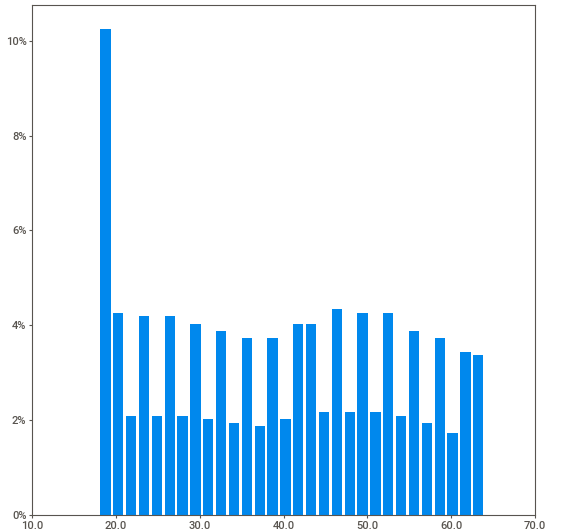
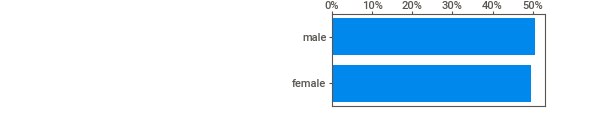
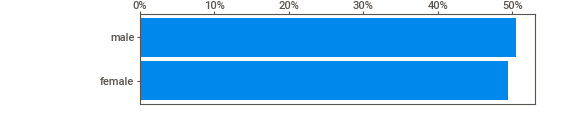
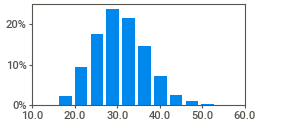
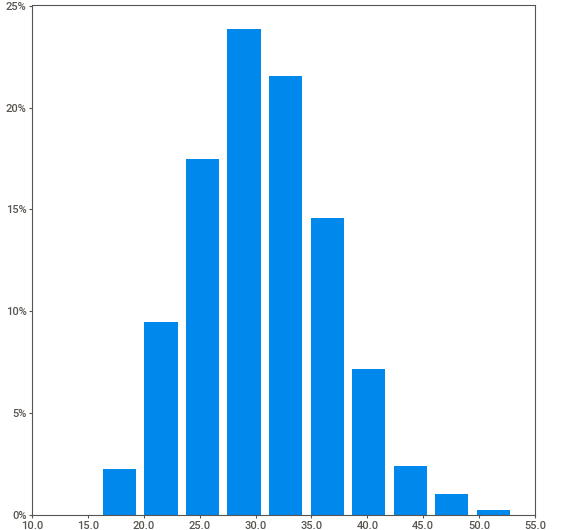
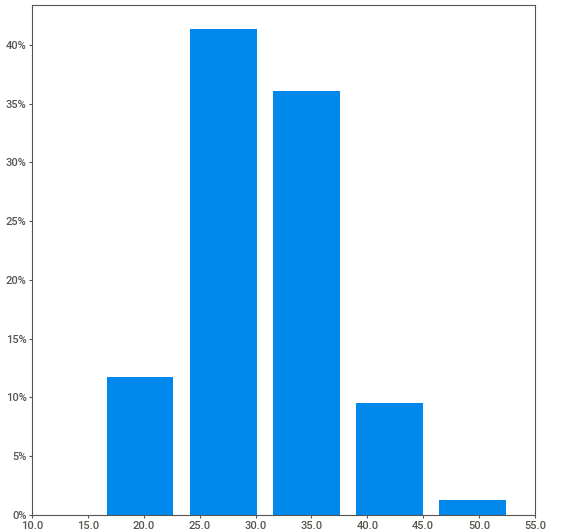
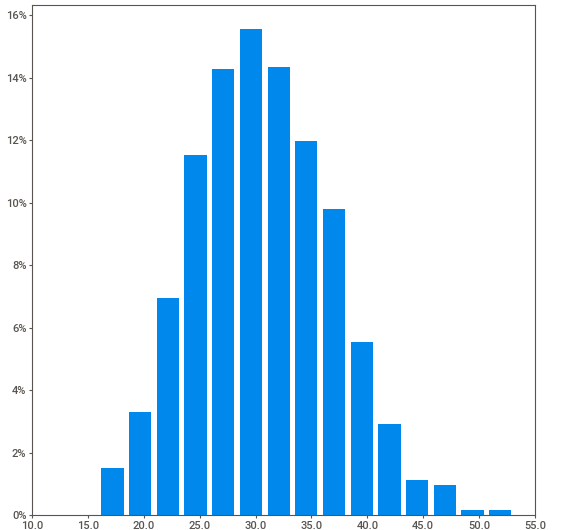
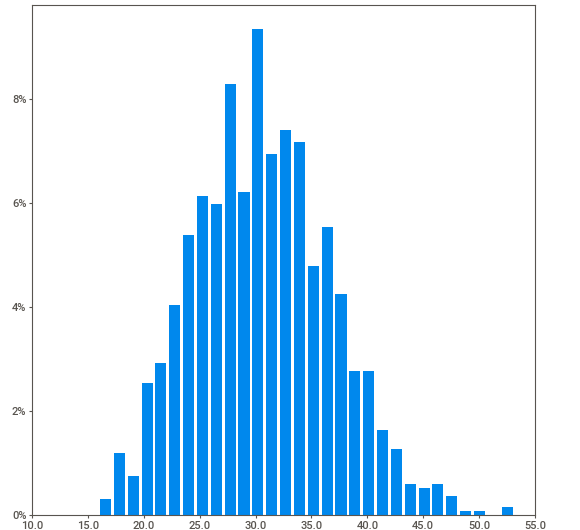
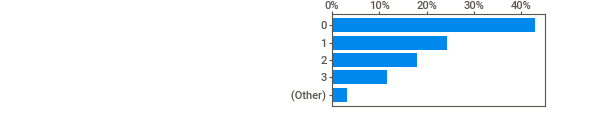
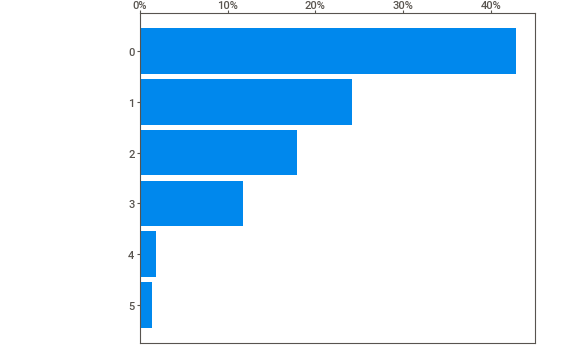
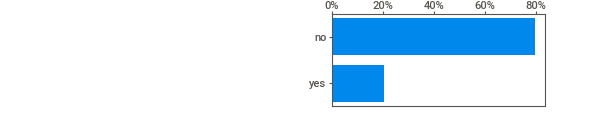
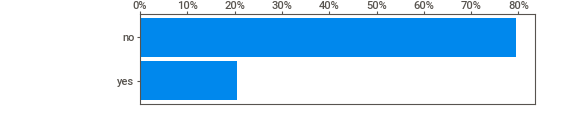
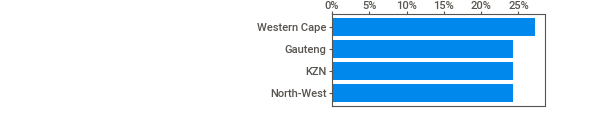
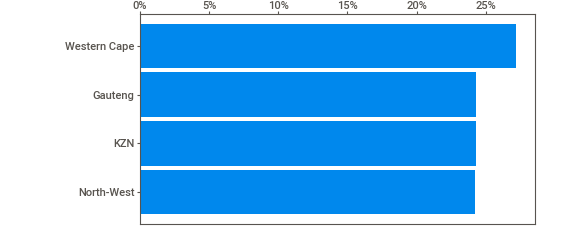
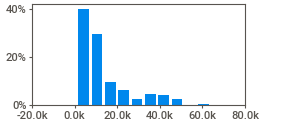
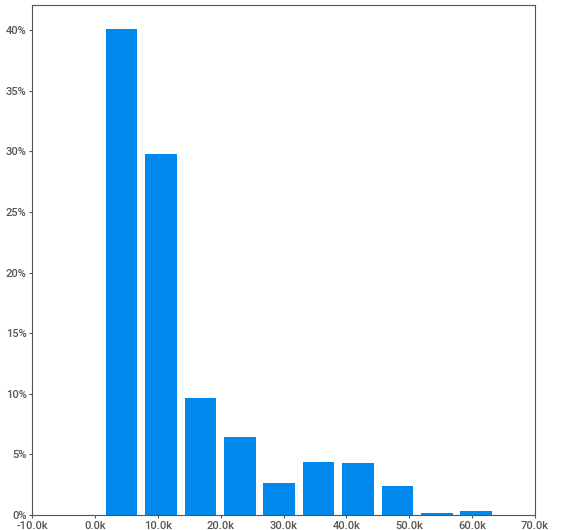
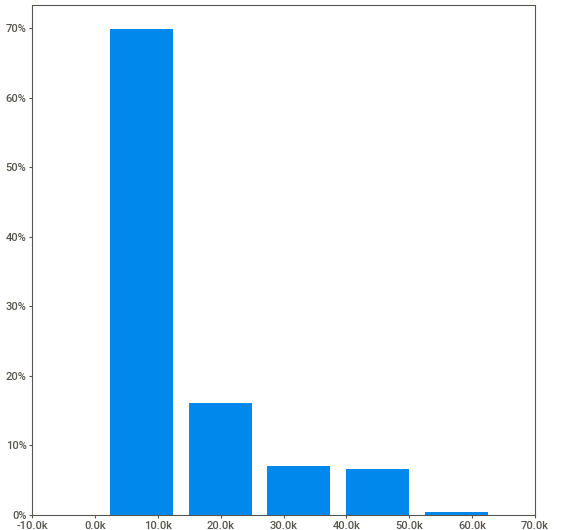
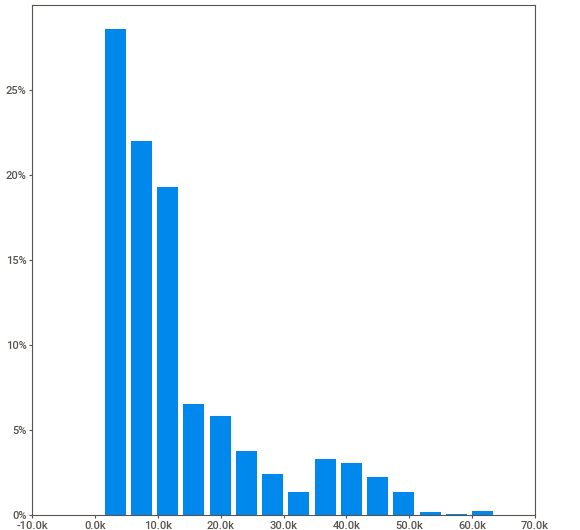
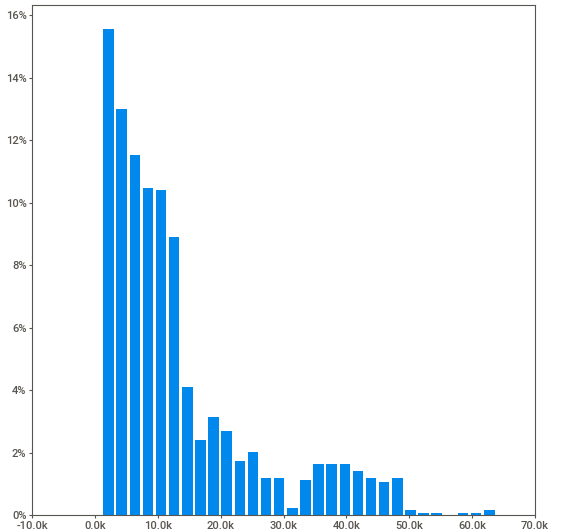
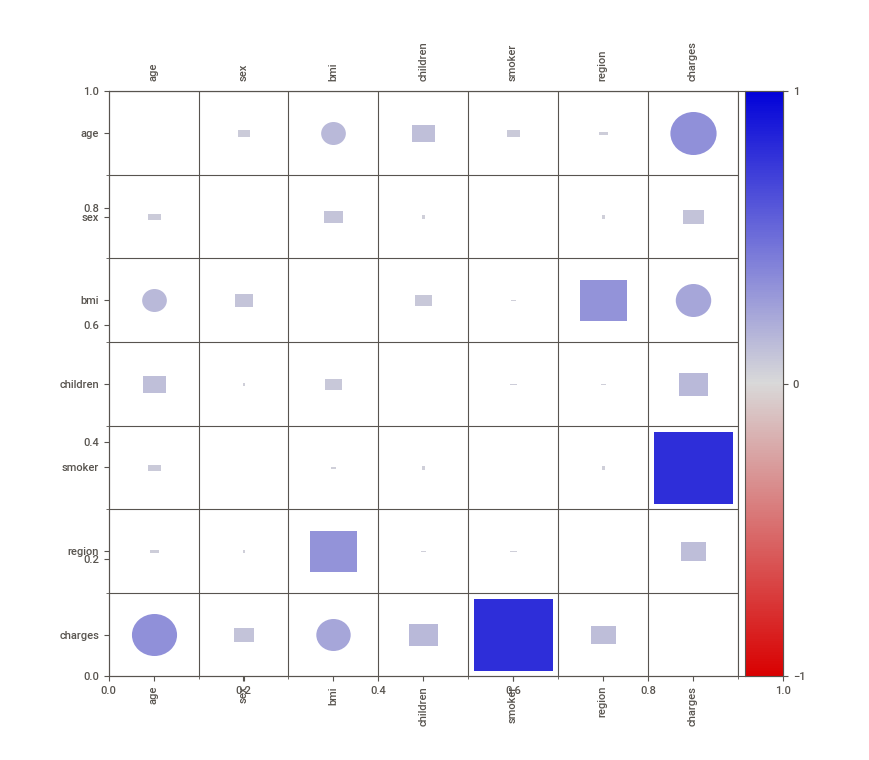
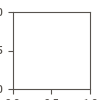

In [3]:
autoEDA = sweetviz.analyze(data)
autoEDA.show_notebook()

In [490]:
data.drop_duplicates(inplace=True)

In [494]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [495]:
# Check for negative ages 
print(data[data['age'] < 0])
print(data[data['charges'] < 0])
print(data[data['bmi'] < 0])





Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []


In [496]:
print(data.value_counts())


age  sex     bmi     children  smoker  region        charges 
18   female  20.790  0         no      Western Cape  1607.51     1
48   female  27.360  1         no      North-West    9447.38     1
             25.850  3         yes     Western Cape  24180.93    1
             22.800  0         no      Gauteng       8269.04     1
47   male    47.520  1         no      Western Cape  8083.92     1
                                                                ..
31   female  25.740  0         no      Western Cape  3756.62     1
             23.600  2         no      Gauteng       4931.65     1
             21.755  0         no      KZN           4134.08     1
30   male    44.220  2         no      Western Cape  4266.17     1
64   male    40.480  0         no      Western Cape  13831.12    1
Name: count, Length: 1337, dtype: int64


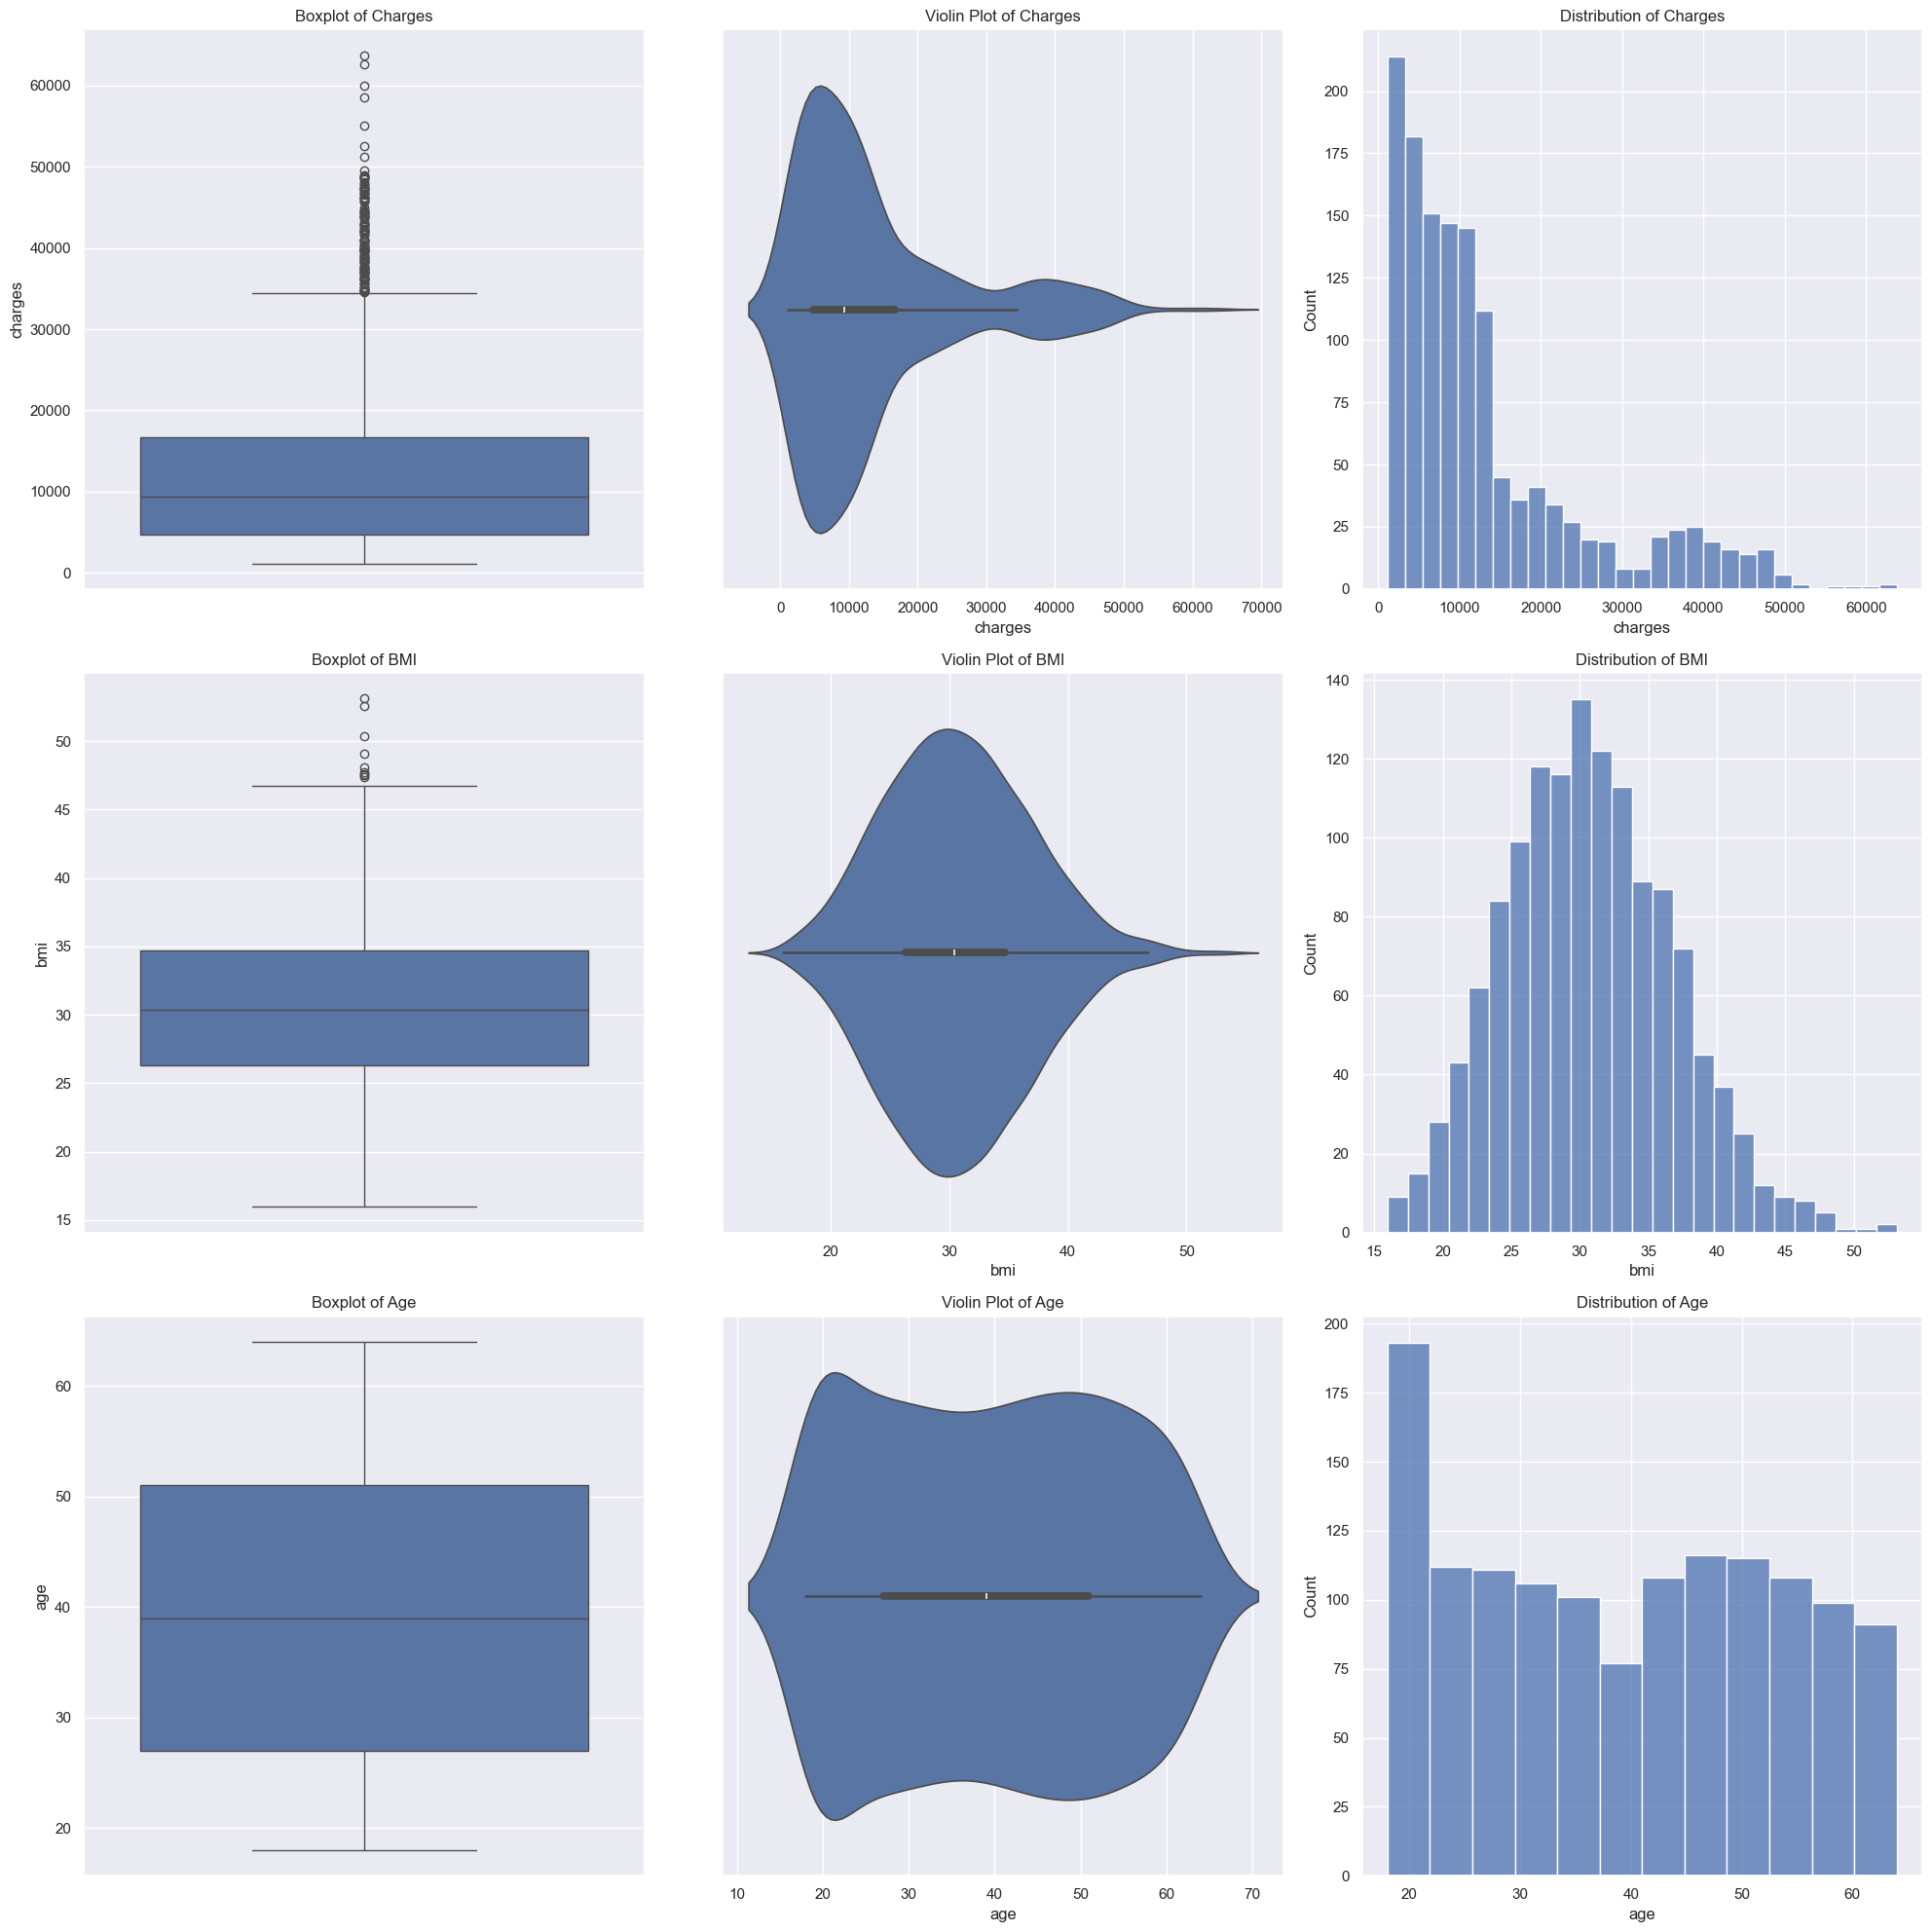

In [498]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# Charges plots
sns.boxplot(data['charges'], ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of Charges')

sns.violinplot(data=data, x='charges', ax=axes[0, 1])
axes[0, 1].set_title('Violin Plot of Charges')

sns.histplot(data['charges'], ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Charges')

# BMI plots
sns.boxplot(data['bmi'], ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of BMI')

sns.violinplot(data=data, x='bmi', ax=axes[1, 1])
axes[1, 1].set_title('Violin Plot of BMI')

sns.histplot(data['bmi'], ax=axes[1, 2])
axes[1, 2].set_title('Distribution of BMI')

# Age plots
sns.boxplot(data['age'], ax=axes[2, 0])
axes[2, 0].set_title('Boxplot of Age')

sns.violinplot(data=data, x='age', ax=axes[2, 1])
axes[2, 1].set_title('Violin Plot of Age')

sns.histplot(data['age'], ax=axes[2, 2])
axes[2, 2].set_title('Distribution of Age')

plt.tight_layout()
plt.show()


### Handling outliers

In [499]:
# for charges
upper_limit = data['charges'].mean()+ 3*data['charges'].std()
lower_limit = data['charges'].mean()- 3*data['charges'].std() 

print(upper_limit," " ,lower_limit)

49610.200609060106   -23051.95733306908


In [500]:
# apply capping
data['charges'] = np.where(data['charges'] < lower_limit, lower_limit, data['charges'])
data['charges'] = np.where(data['charges'] > upper_limit, upper_limit, data['charges'])

In [501]:
# for bmi
upper_limit = data['bmi'].mean()+ 3*data['bmi'].std()
lower_limit = data['bmi'].mean()- 3*data['bmi'].std() 

print(upper_limit," " ,lower_limit)

48.96485698651382   12.362046528819015


In [502]:
# apply capping
data['bmi'] = np.where(data['bmi'] < lower_limit, lower_limit, data['bmi'])
data['bmi'] = np.where(data['bmi'] > upper_limit, upper_limit, data['bmi'])


In [503]:
# for age
upper_limit = data['age'].mean()+ 3*data['age'].std()
lower_limit = data['age'].mean()- 3*data['age'].std() 

print(upper_limit," " ,lower_limit)

81.35513731989636   -2.9108590850421976


In [504]:
# apply capping
data['age'] = np.where(data['age'] < lower_limit, lower_limit, data['age'])
data['age'] = np.where(data['age'] > upper_limit, upper_limit, data['age'])


Plot after outliers removal

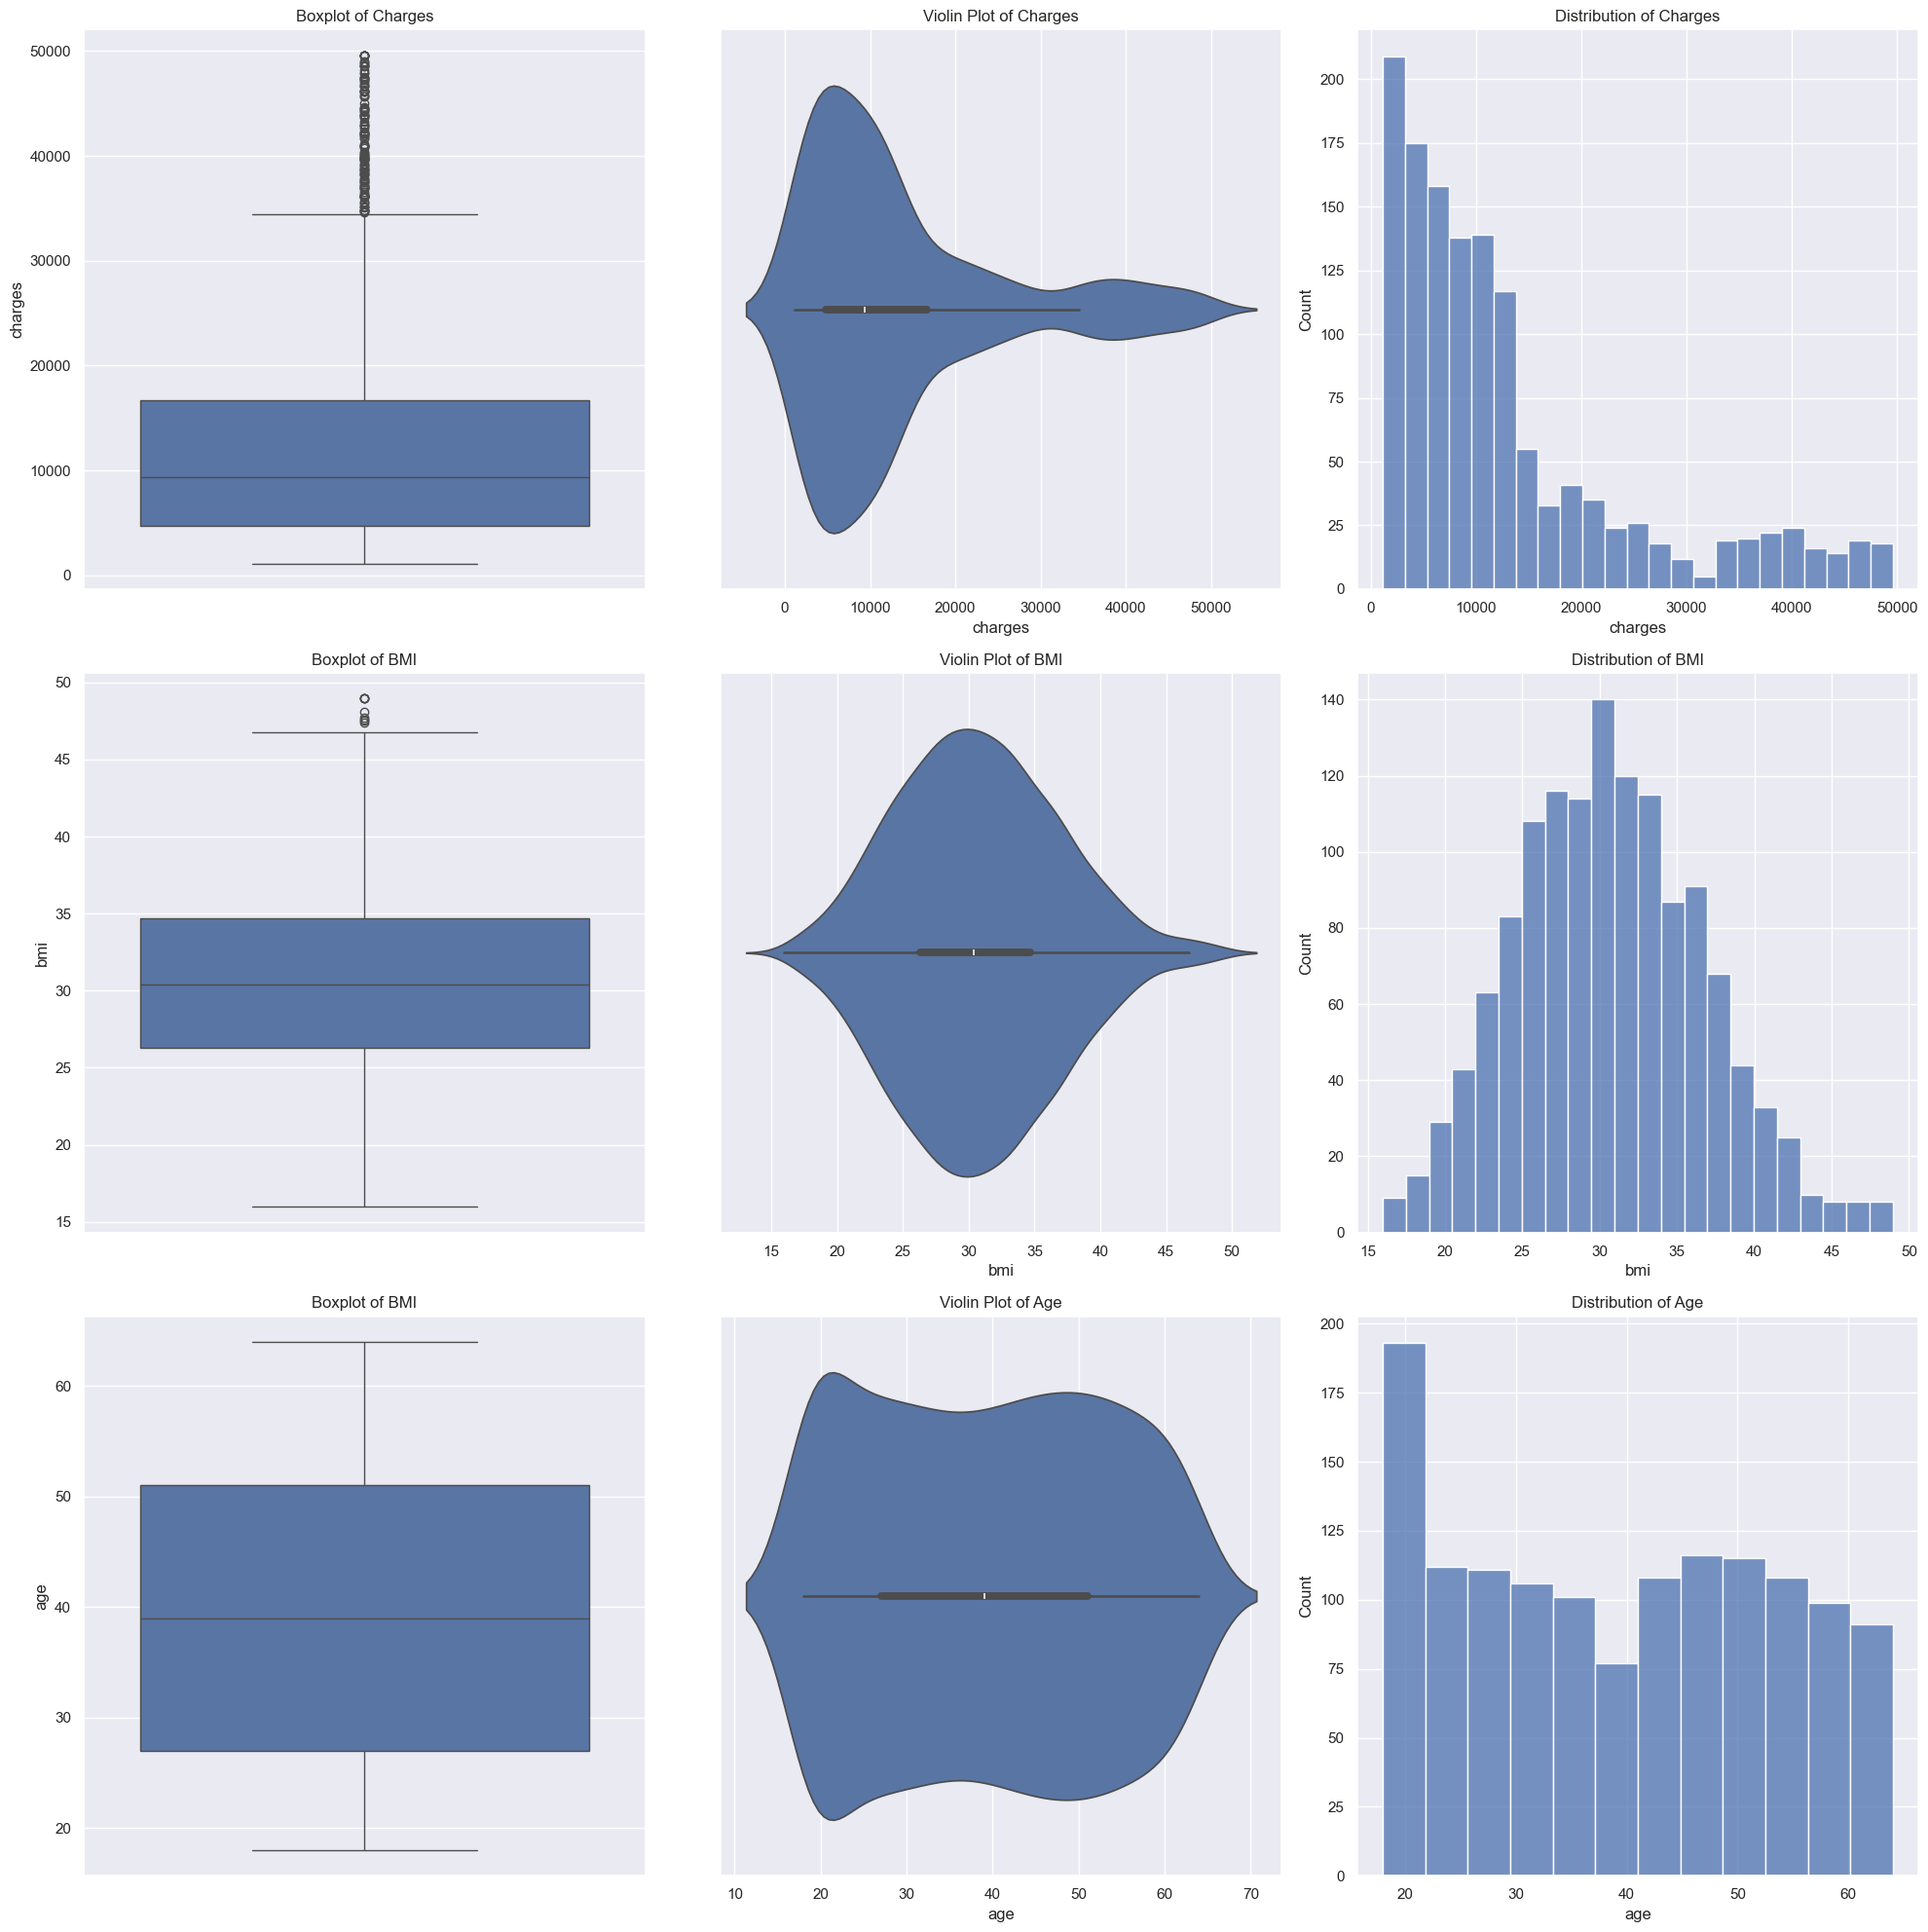

(None,)

In [505]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# charges
sns.boxplot(data['charges'], ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of Charges')

sns.violinplot(data=data, x='charges', ax=axes[0, 1])
axes[0, 1].set_title('Violin Plot of Charges')

sns.histplot(data['charges'], ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Charges')


# bmi plots
sns.boxplot(data['bmi'], ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of BMI')

sns.violinplot(data=data, x='bmi', ax=axes[1, 1])
axes[1, 1].set_title('Violin Plot of BMI')

sns.histplot(data['bmi'], ax=axes[1, 2])
axes[1, 2].set_title('Distribution of BMI')



# age
sns.boxplot(data['age'], ax=axes[2, 0])
axes[2, 0].set_title('Boxplot of BMI')

sns.violinplot(data=data, x='age', ax=axes[2, 1])
axes[2, 1].set_title('Violin Plot of Age')

sns.histplot(data['age'], ax=axes[2, 2])
axes[2, 2].set_title('Distribution of Age')

plt.tight_layout()
plt.show(),  

In [506]:
""" ""
Define the lower and upper percentiles
lower_percentile = data['bmi'].quantile(0.01)
upper_percentile = data['bmi'].quantile(0.99)

# Filter out outliers
data['bmi']= data[(data['bmi'] > lower_percentile) | (data['bmi'] < upper_percentile)]

# Display outliers
print(data['bmi'])

"""""

' ""\nDefine the lower and upper percentiles\nlower_percentile = data[\'bmi\'].quantile(0.01)\nupper_percentile = data[\'bmi\'].quantile(0.99)\n\n# Filter out outliers\ndata[\'bmi\']= data[(data[\'bmi\'] > lower_percentile) | (data[\'bmi\'] < upper_percentile)]\n\n# Display outliers\nprint(data[\'bmi\'])\n\n'

### VISUALIZATION USING SEABORN

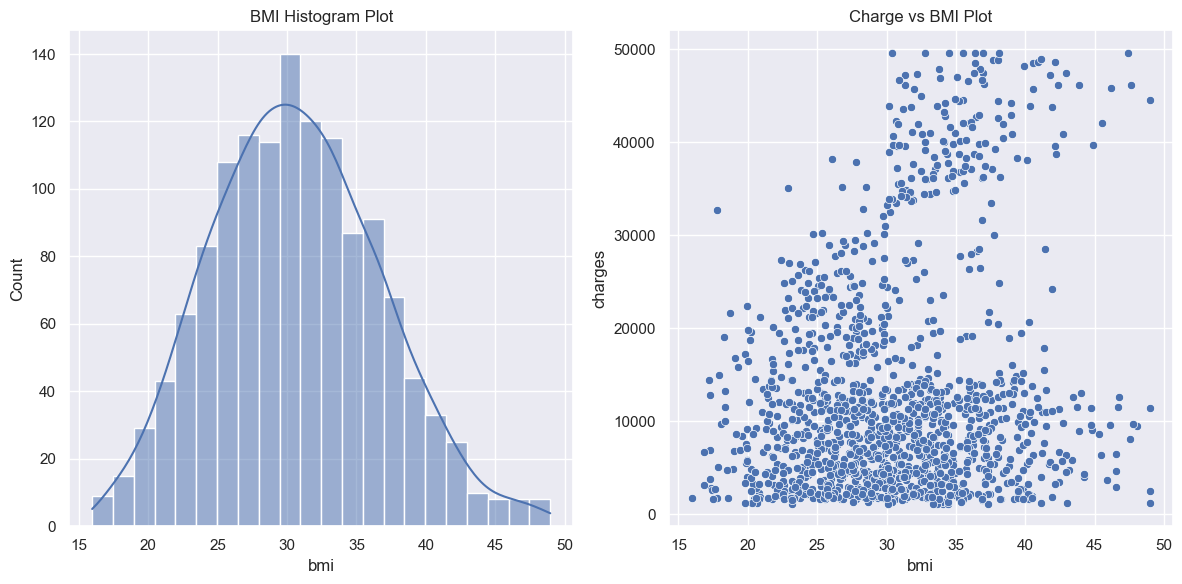

In [510]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

# Histogram for age with hue for sex
sns.histplot(data=data, x='bmi',  kde=True, ax=axes[0])
axes[0].set_title('BMI Histogram Plot')

# Scatter plot for age vs charges
sns.scatterplot(data=data, x='bmi', y='charges', ax=axes[1])
axes[1].set_title('Charge vs BMI Plot')

plt.tight_layout()
plt.show()


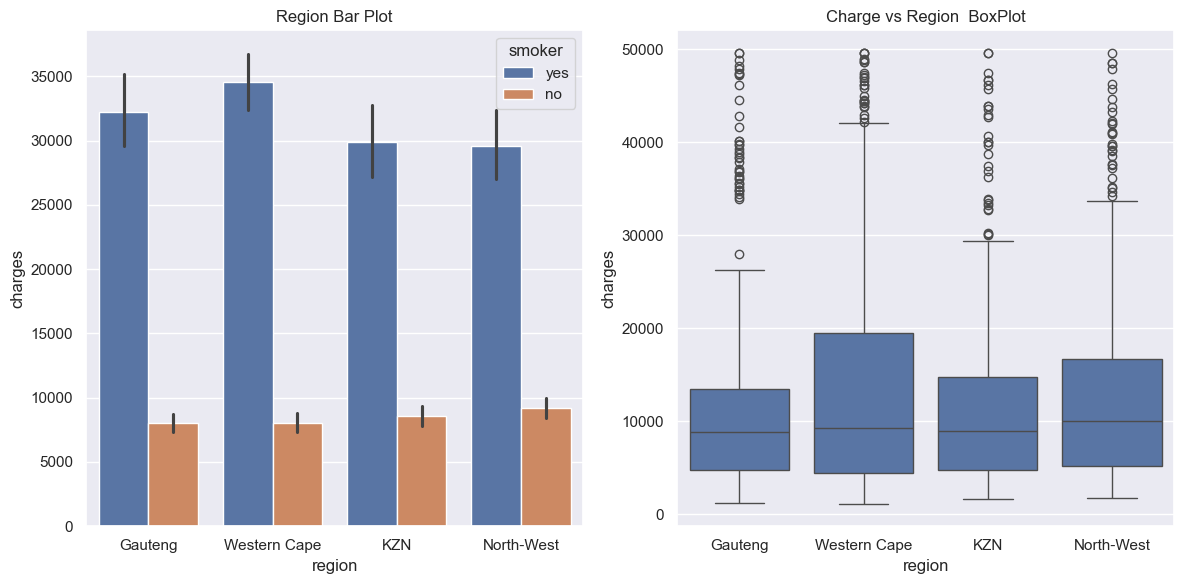

In [511]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

# Histogram for age with hue for sex
sns.barplot(data=data, x='region', y='charges',  hue='smoker',ax=axes[0])
axes[0].set_title('Region Bar Plot')

# Scatter plot for age vs charges
sns.boxplot(data=data, x='region', y='charges', ax=axes[1])
axes[1].set_title('Charge vs Region  BoxPlot')

plt.tight_layout()
plt.show()


In [512]:
pivot_data = data.pivot_table(index='region', columns='smoker', values='charges', aggfunc='mean')


In [513]:
print(pivot_data)


smoker                 no           yes
region                                 
Gauteng       8019.285019  32190.357435
KZN           8582.466955  29917.237262
North-West    9165.531946  29539.791949
Western Cape  8032.216300  34546.723640


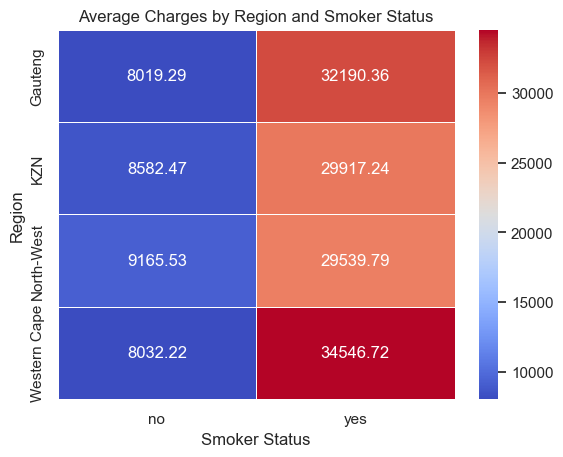

In [514]:
sns.heatmap(pivot_data, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Average Charges by Region and Smoker Status")
plt.ylabel("Region")
plt.xlabel("Smoker Status")
plt.show()


In [515]:
pivot_data_age = data.pivot_table(index='children', columns='smoker', values='charges', aggfunc='mean')



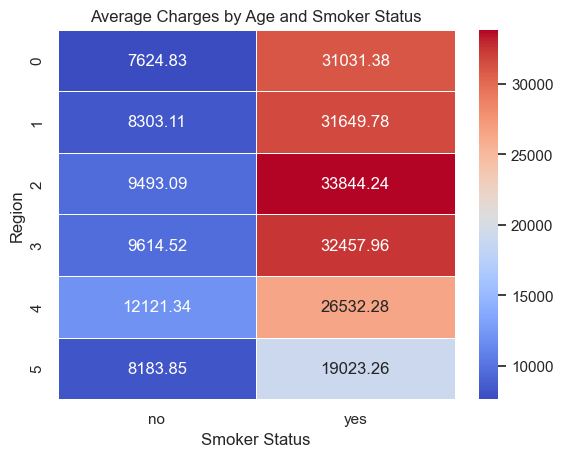

In [516]:
sns.heatmap(pivot_data_age, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Average Charges by Age and Smoker Status")
plt.ylabel("Region")
plt.xlabel("Smoker Status")
plt.show()


In [517]:
pivot_data_sex = data.pivot_table(index='sex', columns='smoker', values='charges', aggfunc='mean')


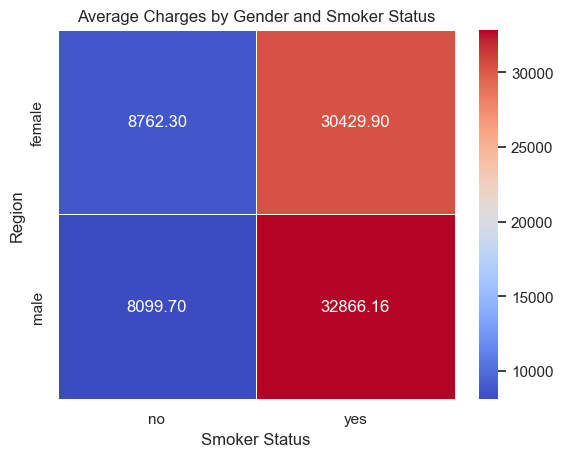

In [518]:
sns.heatmap(pivot_data_sex, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Average Charges by Gender and Smoker Status")
plt.ylabel("Region")
plt.xlabel("Smoker Status")
plt.show()


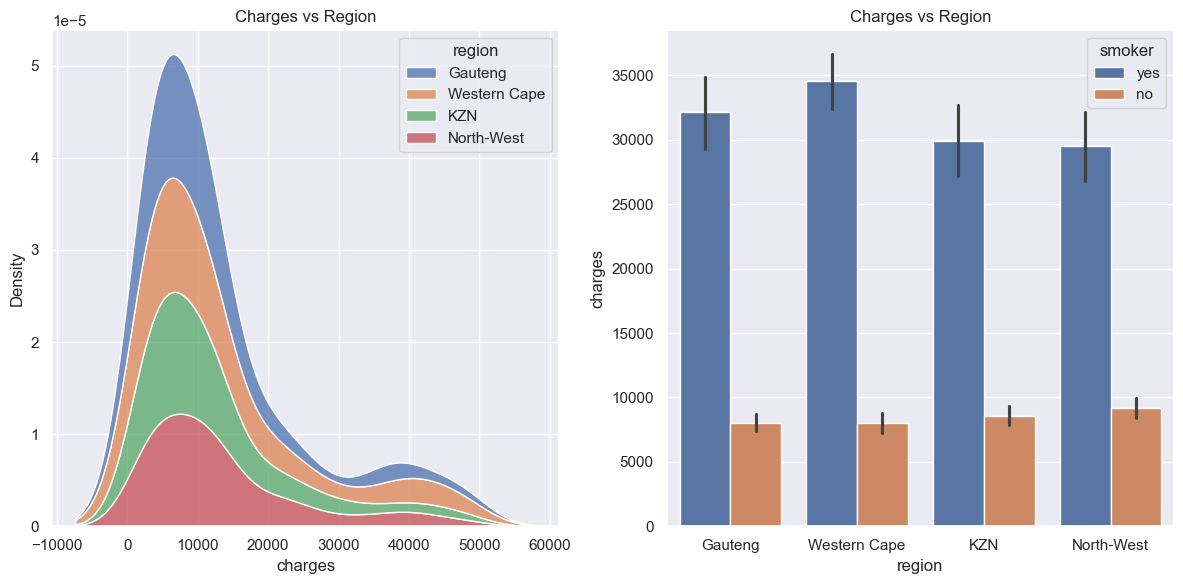

In [519]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.kdeplot(data=data, x="charges", hue="region", multiple="stack", ax=axes[0])
axes[0].set_title('Charges vs Region')

sns.barplot(data=data, x='region', y='charges', hue='smoker', ax=axes[1])
axes[1].set_title('Charges vs Region')

plt.tight_layout()
plt.show()

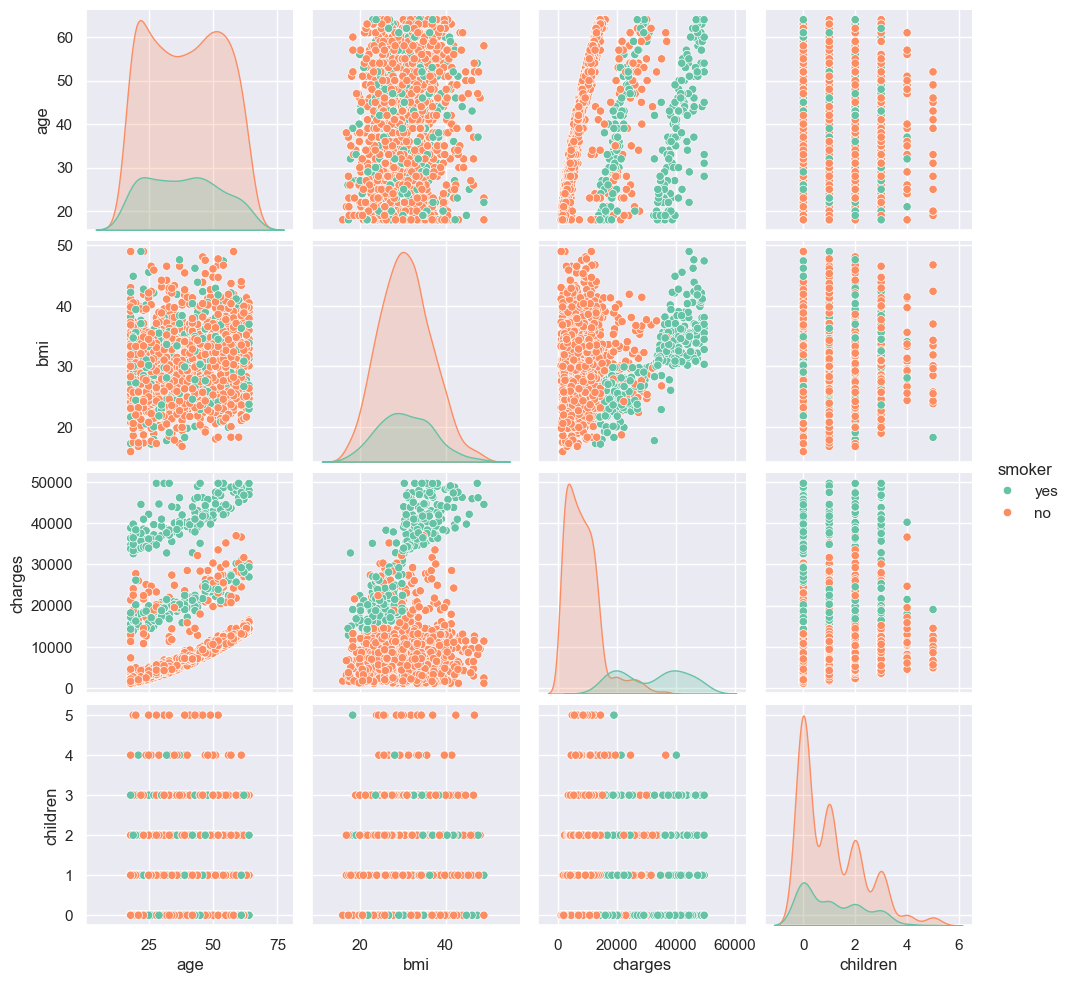

In [521]:
sns.pairplot(data=data, vars=['age', 'bmi', 'charges','children'], hue='smoker', palette="Set2")


### LINEAR REGRESSION ASSUMPTIONS ###

### MODEL SELECTION: Regression assumption
1. Linearity - The relationship between the independent variable(s) (X) and the dependent variable (Y) must be linear.
2. no multicolliarity - Independent variables (predictors) should not be highly correlated with each other.
3. normality of Residuals and Homoscedasticity:  The residuals (errors) should follow a normal distribution,and residuals should have a mean of zero and equal variance across all levels of the predictors.
4. Indipendence fo errors ( no endogeneity e and x)
5. no autocorrelation between residuals

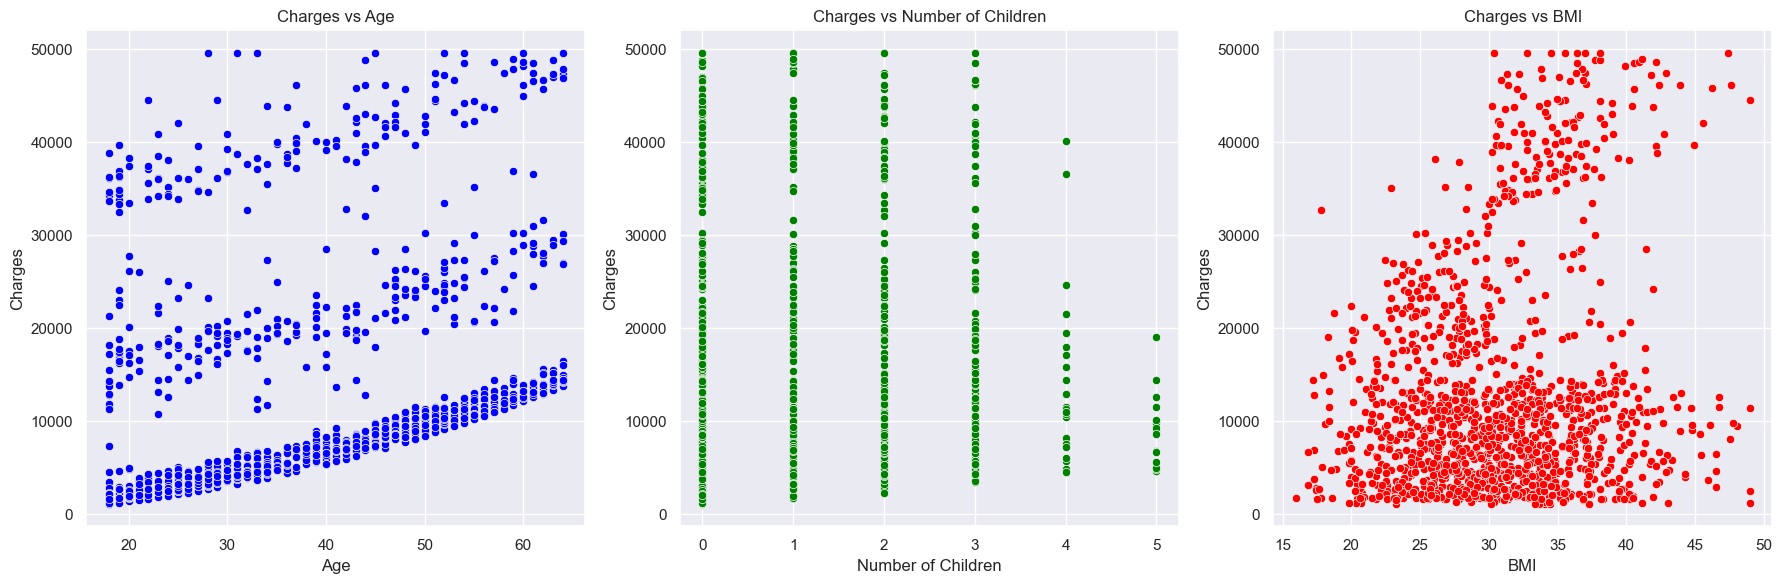

In [522]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Charges vs Age
sns.scatterplot(data=data, x='age', y='charges', ax=axes[0], color='blue')
axes[0].set_title('Charges vs Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Charges')

# Plot 2: Charges vs Number of Children
sns.scatterplot(data=data, x='children', y='charges', ax=axes[1], color='green')
axes[1].set_title('Charges vs Number of Children')
axes[1].set_xlabel('Number of Children')
axes[1].set_ylabel('Charges')

# Plot 3: Charges vs BMI
sns.scatterplot(data=data, x='bmi', y='charges', ax=axes[2], color='red')
axes[2].set_title('Charges vs BMI')
axes[2].set_xlabel('BMI')
axes[2].set_ylabel('Charges')


plt.tight_layout()
plt.show()


#### No Multicollinearity assumption

- using vif from the stats models and heatmap
- if vif= 1 no multicollinearity
- if vif >10 : its high then we have to drop one
- if vif betweem 1< VIF >5 moderate

In [523]:

X = sm.add_constant(data[['age', 'children', 'bmi']]) 

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

    Feature        VIF
0     const  32.074543
1       age   1.014182
2  children   1.001805
3       bmi   1.012612


####  Checking using Heatmap sns

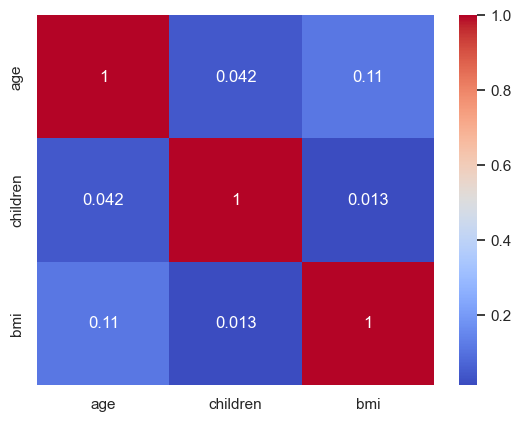

In [524]:
correlation_matrix = data[['age', 'children', 'bmi']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

### LOG TRANSFOMATION
Various transformations, including Square, Cube, and Box-Cox, were tested to improve the normality of the data. After evaluating the results using normality graphs, the logarithmic (Log) transformation was chosen as it showed the best improvement in normality compared to the other methods.

In [525]:
log_charges= np.log(data['charges'])
data['log_charges']= log_charges
data

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19.0,female,27.900,0,yes,Gauteng,16884.92,9.734176
1,18.0,male,33.770,1,no,Western Cape,1725.55,7.453301
2,28.0,male,33.000,3,no,Western Cape,4449.46,8.400538
3,33.0,male,22.705,0,no,KZN,21984.47,9.998092
4,32.0,male,28.880,0,no,KZN,3866.86,8.260198
...,...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3,no,KZN,10600.55,9.268661
1334,18.0,female,31.920,0,no,North-West,2205.98,7.698927
1335,18.0,female,36.850,0,no,Western Cape,1629.83,7.396231
1336,21.0,female,25.800,0,no,Gauteng,2007.95,7.604870


<Axes: xlabel='log_charges', ylabel='Count'>

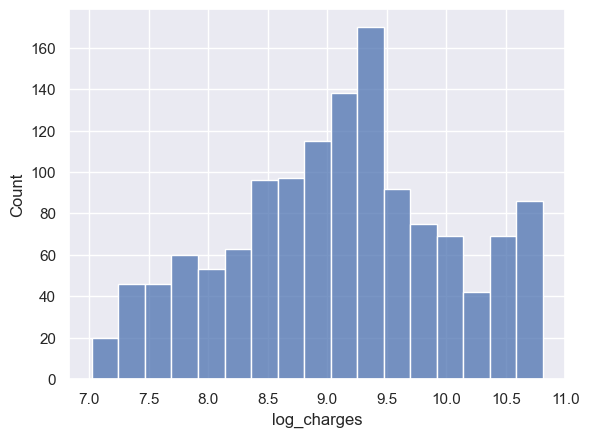

In [526]:
sns.histplot(data['log_charges'])

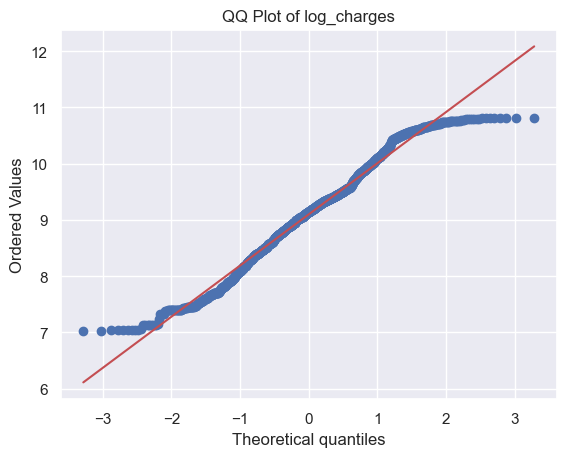

In [527]:
probplot(data['log_charges'], dist="norm", plot=plt)
plt.title('QQ Plot of log_charges')
plt.show()

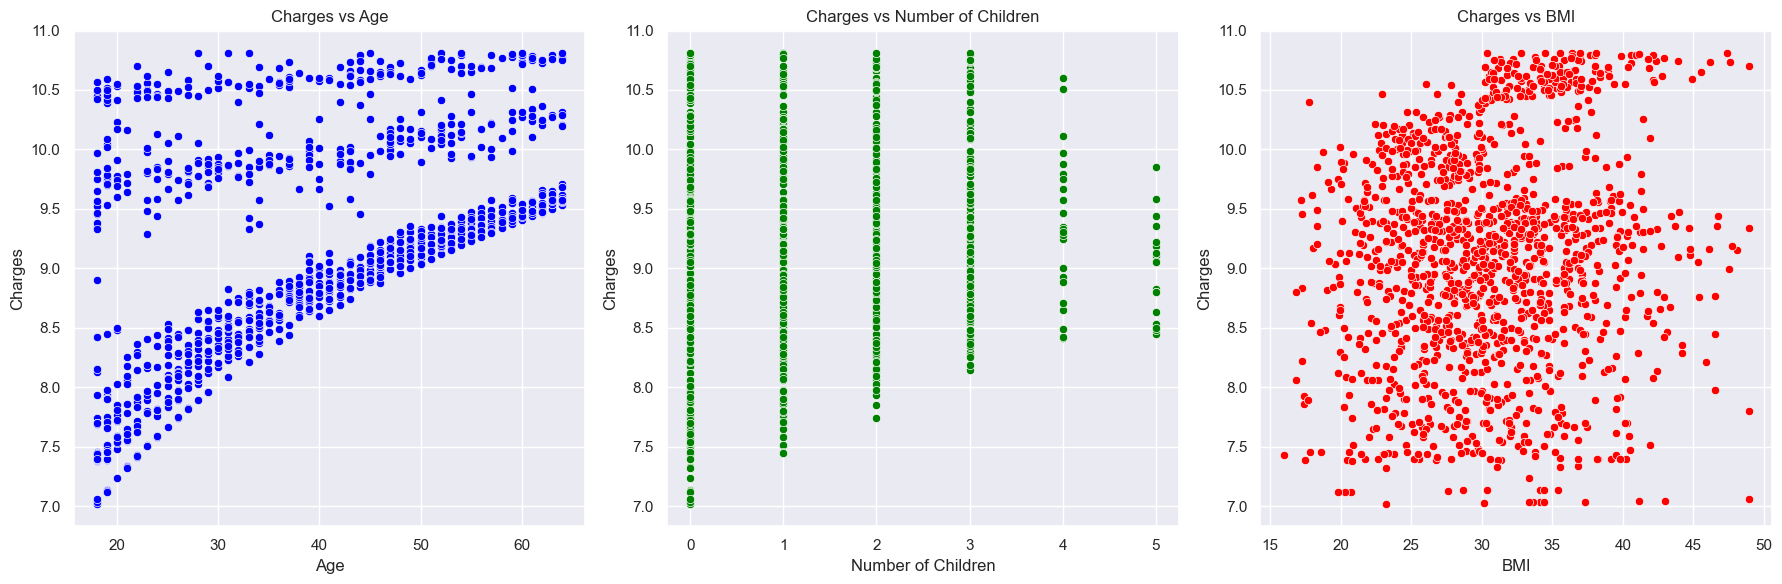

In [528]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Charges vs Age
sns.scatterplot(data=data, x='age', y='log_charges', ax=axes[0], color='blue')
axes[0].set_title('Charges vs Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Charges')

# Plot 2: Charges vs Number of Children
sns.scatterplot(data=data, x='children', y='log_charges', ax=axes[1], color='green')
axes[1].set_title('Charges vs Number of Children')
axes[1].set_xlabel('Number of Children')
axes[1].set_ylabel('Charges')

# Plot 3: Charges vs BMI
sns.scatterplot(data=data, x='bmi', y='log_charges', ax=axes[2], color='red')
axes[2].set_title('Charges vs BMI')
axes[2].set_xlabel('BMI')
axes[2].set_ylabel('Charges')


plt.tight_layout()
plt.show()


### Dummies variable

In [529]:
dummies = pd.get_dummies(data, columns=['sex', 'smoker', 'region'])
data1= dummies.iloc[:, 5:].astype(int)
data1


,sex_female,sex_male,smoker_no,smoker_yes,region_Gauteng,region_KZN,region_North-West,region_Western Cape
0,1,0,0,1,1,0,0,0
1,0,1,1,0,0,0,0,1
2,0,1,1,0,0,0,0,1
3,0,1,1,0,0,1,0,0
4,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
1333,0,1,1,0,0,1,0,0
1334,1,0,1,0,0,0,1,0
1335,1,0,1,0,0,0,0,1
1336,1,0,1,0,1,0,0,0


In [530]:
dummies.columns

Index(['age', 'bmi', 'children', 'charges', 'log_charges', 'sex_female',
       'sex_male', 'smoker_no', 'smoker_yes', 'region_Gauteng', 'region_KZN',
       'region_North-West', 'region_Western Cape'],
      dtype='object')

In [531]:
data2= dummies.iloc[:, :5]

data2

,age,bmi,children,charges,log_charges
0,19.0,27.900,0,16884.92,9.734176
1,18.0,33.770,1,1725.55,7.453301
2,28.0,33.000,3,4449.46,8.400538
3,33.0,22.705,0,21984.47,9.998092
4,32.0,28.880,0,3866.86,8.260198
...,...,...,...,...,...
1333,50.0,30.970,3,10600.55,9.268661
1334,18.0,31.920,0,2205.98,7.698927
1335,18.0,36.850,0,1629.83,7.396231
1336,21.0,25.800,0,2007.95,7.604870


In [532]:
data = pd.concat([data2, data1], axis=1)
data

,age,bmi,children,charges,log_charges,sex_female,sex_male,smoker_no,smoker_yes,region_Gauteng,region_KZN,region_North-West,region_Western Cape
0,19.0,27.900,0,16884.92,9.734176,1,0,0,1,1,0,0,0
1,18.0,33.770,1,1725.55,7.453301,0,1,1,0,0,0,0,1
2,28.0,33.000,3,4449.46,8.400538,0,1,1,0,0,0,0,1
3,33.0,22.705,0,21984.47,9.998092,0,1,1,0,0,1,0,0
4,32.0,28.880,0,3866.86,8.260198,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50.0,30.970,3,10600.55,9.268661,0,1,1,0,0,1,0,0
1334,18.0,31.920,0,2205.98,7.698927,1,0,1,0,0,0,1,0
1335,18.0,36.850,0,1629.83,7.396231,1,0,1,0,0,0,0,1
1336,21.0,25.800,0,2007.95,7.604870,1,0,1,0,1,0,0,0


In [533]:
data.drop(['charges'], axis=1, inplace=True)
data

,age,bmi,children,log_charges,sex_female,sex_male,smoker_no,smoker_yes,region_Gauteng,region_KZN,region_North-West,region_Western Cape
0,19.0,27.900,0,9.734176,1,0,0,1,1,0,0,0
1,18.0,33.770,1,7.453301,0,1,1,0,0,0,0,1
2,28.0,33.000,3,8.400538,0,1,1,0,0,0,0,1
3,33.0,22.705,0,9.998092,0,1,1,0,0,1,0,0
4,32.0,28.880,0,8.260198,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50.0,30.970,3,9.268661,0,1,1,0,0,1,0,0
1334,18.0,31.920,0,7.698927,1,0,1,0,0,0,1,0
1335,18.0,36.850,0,7.396231,1,0,1,0,0,0,0,1
1336,21.0,25.800,0,7.604870,1,0,1,0,1,0,0,0


In [534]:
data.to_csv('output.csv', index=False)


### EDA SUMNARY ALAYSIS
**Insights**

Exploratory Data Analysis (EDA) provides valuable insights into the dataset before fitting it to a predictive model. Key observations include:

1. **Age Distribution**: The dataset primarily consists of individuals around 20 years old, suggesting younger individuals may influence premium charges due to higher perceived risk.
2. **Premium Charges**: The distribution of premium charges is skewed, with most individuals having lower premiums, but some facing significantly higher charges. Factors like **BMI**, **age**, and **smoking** contribute to higher premiums.
3. **Impact of BMI, Age, and Smoking**: Higher **BMI**, older **age**, and **smoking** are positively correlated with higher premium charges due to associated health risks.
4. **Geographic Analysis**: The **Western Cape** has the highest premium charges, likely due to regional factors such as population density and healthcare access.
